In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib import rcParams



### Load data

In [2]:
# Load the data
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
print(df.columns)
print(df['codLocation'].unique())

local = 1711115
df = df[df['codLocation'] == local]
df.head()

Index(['Avaliacoes Total', 'Avaliacoes Apartamentos', 'Avaliacoes Moradias',
       'Capital Divida Total', 'Capital Divida 3M', 'Capital Divida 6M',
       'Capital Divida 12M', 'Juros Totais', 'Capital Amortizado',
       'Unemployed population', 'Prestacao Media', 'Mês', 'Ano', 'mes', 'ano',
       '1 mês (Euribor)', '3 meses (Euribor)', '6 meses (Euribor)',
       '12 meses (Euribor)',
       'Número de beneficiários de subsídio de desemprego (milhares)-mensal',
       'Indicador coincidente para a atividade económica-Mensal-TVH',
       'Indicador coincidente para o consumo privado-Mensal-TVH',
       'Endividamento dos particulares-TVA', 'Endividamento dos particulares',
       'Endividamento dos particulares junto de empresas não financeiras',
       'Endividamento dos particulares junto do setor financeiro',
       'Endividamento dos particulares junto das administrações públicas',
       'Endividamento dos particulares junto de particulares',
       'Endividamento dos particul

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1317,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,202955.666667,185891.371583,202.568216,0.0,3.0,1104.000000,993.847679,44.333333,7.0
1318,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,169080.000000,160455.685792,200.624071,9.0,-2.0,890.666667,833.423840,24.333333,3.0
1319,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,134624.333333,147097.842896,194.956268,-2.0,-2.0,675.333333,759.711920,1.000000,0.0
1320,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,134935.000000,141571.421448,205.506042,0.0,3.0,673.666667,710.855960,1.666667,0.0
1321,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,134707.000000,137953.710724,207.629057,0.0,-4.0,665.000000,678.927980,3.000000,0.0


In [3]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


### Train the model

In [11]:
param_grid = {
    'n_estimators': [200, 400, 500, 800],
    'max_features': [None, 0.5, 0.75], #'sqrt', 'log2', 
    'max_depth': [None, 5], # , 10, 20, 30
    'min_samples_split': [3, 5, 10], # , 15, 20
    'min_samples_leaf': [1, 2] # , 3, 4, 5
}
# Overtting: aumentar min_samples_split, min_samples_leaf
# diminuir max_depth, n_estimators, max_features

scoring = {
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'explained_variance': make_scorer(explained_variance_score)
}


grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=10,  # número de folds para validação cruzada
                           n_jobs=-1,  # usar todos os núcleos disponíveis
                           verbose=3,  # nível de verbosidade
                           scoring=scoring,
                           refit='r2')

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_params = grid_search.best_params_

print("Best model:", best_rf_model)
print("Best params:", best_rf_params)

# Best params: {'max_depth': None, 'max_features': None, 
# 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}

# Best params: {'max_depth': None, 'max_features': None, 
# 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best model: RandomForestRegressor(max_features=None, min_samples_split=3, n_estimators=200,
                      random_state=42)
Best params: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


### Metrics

In [12]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [27]:
# best_rf_model = RandomForestRegressor(max_features=None, 
#                                       min_samples_split=3, 
#                                       n_estimators=200,
#                                       random_state=42).fit(X_train, 
#                                                            y_train)

In [28]:
from sklearn.model_selection import TimeSeriesSplit

print("\nAvaliação sem TimeSeriesSplit:")
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

mae_train, r2_train, mse_train, acc_train = calcular_metricas(y_train, y_train_pred_rf, "Treino")
mae_test, r2_test, mse_test, acc_test = calcular_metricas(y_test, y_test_pred_rf, "Teste")


print("\nAvaliação com TimeSeriesSplit:")
tscv = TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_tscv, X_test_tscv = X.iloc[train_index], X.iloc[test_index]
    y_train_tscv, y_test_tscv = y.iloc[train_index], y.iloc[test_index]
    
    best_rf_model.fit(X_train_tscv, y_train_tscv)
    y_pred_tscv = best_rf_model.predict(X_test_tscv)
    
    mae_testT, r2_testT, mse_testT, acc_testT = calcular_metricas(y_test_tscv, 
                                                              y_pred_tscv, 
                                                              f"TimeSeries Split {i+1}")



Avaliação sem TimeSeriesSplit:
Treino: MAE: 346.52, R²: 1.00, MSE: 999882.43, Acurácia: 99.80%
Teste: MAE: 7229.72, R²: -1.79, MSE: 78462192.02, Acurácia: 96.65%

Avaliação com TimeSeriesSplit:
TimeSeries Split 1: MAE: 9503.38, R²: -19.08, MSE: 96992470.71, Acurácia: 94.47%
TimeSeries Split 2: MAE: 2745.27, R²: -0.81, MSE: 12085647.71, Acurácia: 98.44%
TimeSeries Split 3: MAE: 14533.34, R²: -2.32, MSE: 302916358.65, Acurácia: 92.49%
TimeSeries Split 4: MAE: 13696.02, R²: -8.53, MSE: 205712048.77, Acurácia: 93.61%
TimeSeries Split 5: MAE: 9654.74, R²: -2.80, MSE: 130400170.59, Acurácia: 95.72%


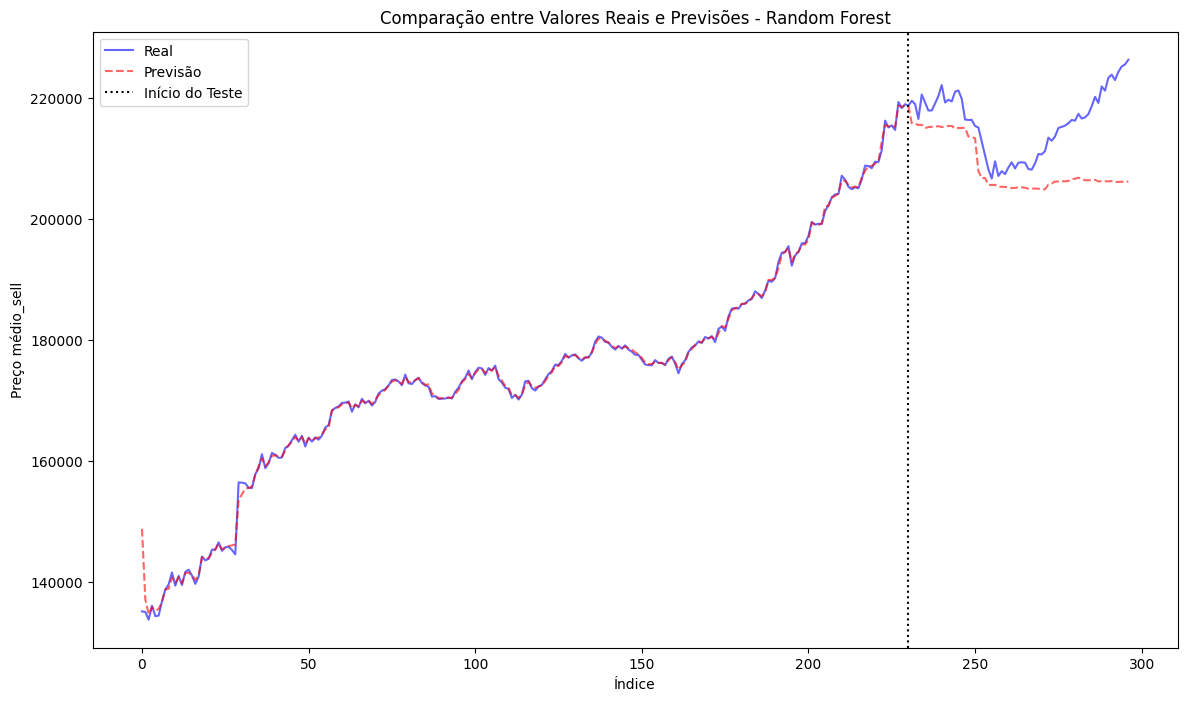

In [29]:

indices = np.concatenate([np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))])
y_real = np.concatenate([y_train, y_test])
y_pred = np.concatenate([y_train_pred_rf, y_test_pred_rf])

plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)

plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', label='Início do Teste')

plt.title('Comparação entre Valores Reais e Previsões - Random Forest')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()
plt.show()


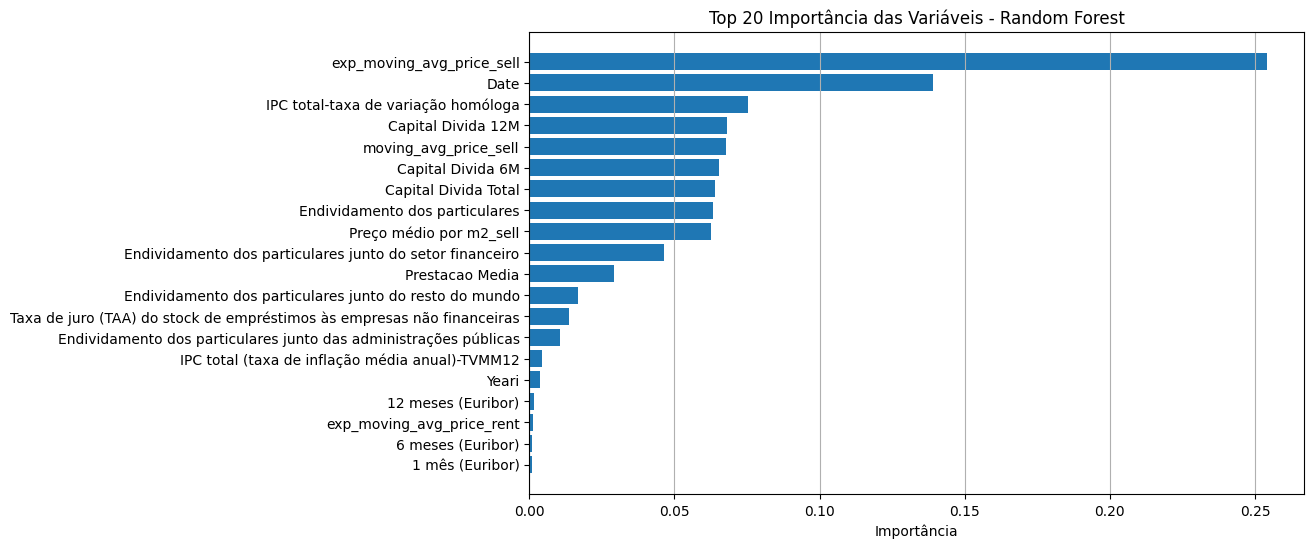

In [30]:

feature_importances = best_rf_model.feature_importances_
feature_names = X.columns  

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx][:20] 
sorted_feature_names = feature_names[sorted_idx][:20]  

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Importância')
plt.title('Top 20 Importância das Variáveis - Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

#### Dados de validacao

In [31]:
y_valid_pred_rf = best_rf_model.predict(X_valid)
mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid, y_valid_pred_rf, "Validação")


Validação: MAE: 90553.18, R²: -563.35, MSE: 8214002952.72, Acurácia: 60.49%


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


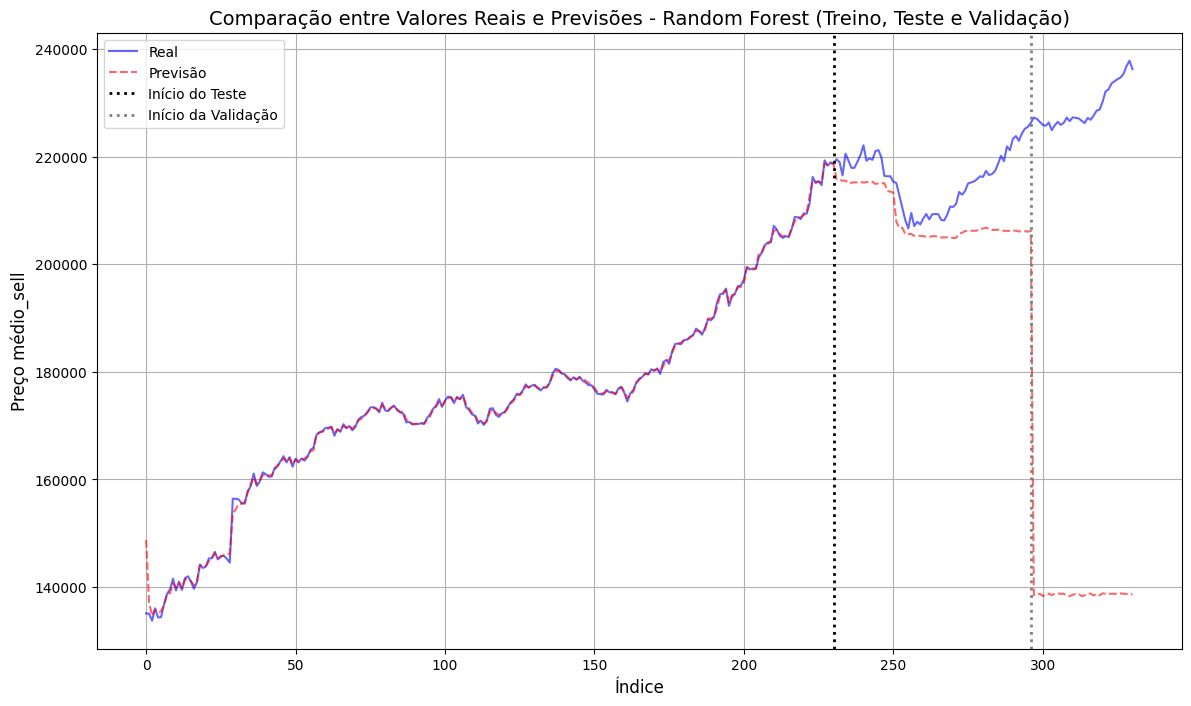

In [34]:
indices = np.concatenate([np.arange(len(y_train)), 
                          np.arange(len(y_train), len(y_train) + len(y_test)),
                          np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_valid))])

y_real = np.concatenate([y_train, y_test, y_valid])

y_pred = np.concatenate([y_train_pred_rf, y_test_pred_rf, y_valid_pred_rf])

plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)

plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', linewidth=2, label='Início do Teste')
plt.axvline(x=len(y_train) + len(y_test) - 1, color='gray', linestyle=':', linewidth=2, label='Início da Validação')

plt.title('Comparação entre Valores Reais e Previsões - Random Forest (Treino, Teste e Validação)', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Preço médio_sell', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Results

In [36]:
resultados = {
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acc_train, acc_test, acc_valid]
}
resultados['Conjunto'].append('TimeSeries Split (Teste)')
resultados['MAE'].append(mae_testT)
resultados['R²'].append(r2_testT)
resultados['MSE'].append(mse_testT)
resultados['Acurácia (%)'].append(acc_testT)

resultados_df = pd.DataFrame(resultados)
resultados_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,346.523558,0.997172,9.998824e+05,99.801723
1,Teste,7229.717923,-1.785762,7.846219e+07,96.650963
2,Validação,90553.178340,-563.350399,8.214003e+09,60.491283
3,TimeSeries Split (Teste),9654.738970,-2.802098,1.304002e+08,95.721746


In [37]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):

    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }


    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    if not os.path.exists(directory):
        os.makedirs(directory)


    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []


    existing_data.append(results_dict_with_model)


    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("Random Forest", local, resultados_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
